In [1]:
!pip install chex
!pip install dm-haiku
!pip install optax
!pip install distrax

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.9/87.9 KB 3.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 352.1/352.1 KB 8.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.9/154.9 KB 2.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.0/318.0 KB 7.2 MB/s eta 0:00:00


In [2]:
import jax
import jax.numpy as jnp
import haiku as hk
import distrax
import chex
import numpy as np
import optax
import matplotlib.pyplot as plt
import time

In [3]:
# Use a EBM formulation of likelihod vs a score formulation of likelihood
ebm = True

# Number of diffusion timesteps to train
n_steps = 100
data_dim = 2

In [4]:
import math

import haiku as hk
import jax
import jax.numpy as jnp
import numpy as np
import optax

import functools

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds

In [5]:
# Define a simple MLP Diffusion Model
class ResnetDiffusionModel(hk.Module):
  """Resnet score model.

  Adds embedding for each scale after each linear layer.
  """

  def __init__(self,
               n_steps,
               n_layers,
               x_dim,
               h_dim,
               emb_dim,
               widen=2,
               emb_type='learned',
               name=None):
    assert emb_type in ('learned', 'sinusoidal')
    super().__init__(name=name)
    self._n_layers = n_layers
    self._n_steps = n_steps
    self._x_dim = x_dim
    self._h_dim = h_dim
    self._emb_dim = emb_dim
    self._widen = widen
    self._emb_type = emb_type

  def __call__(self, x, t):

    x = jnp.atleast_2d(x)
    t = jnp.atleast_1d(t)

    chex.assert_shape(x, (None, self._x_dim))
    chex.assert_shape(t, (None,))
    chex.assert_type([x, t], [jnp.float32, jnp.int64])

    if self._emb_type == 'learned':
      emb = hk.Embed(self._n_steps, self._emb_dim)(t)
    else:
      emb = timestep_embedding(t, self._emb_dim)

    x = hk.Linear(self._h_dim)(x)

    for _ in range(self._n_layers):
      # get layers and embeddings
      layer_h = hk.Linear(self._h_dim * self._widen)
      layer_emb = hk.Linear(self._h_dim * self._widen)
      layer_int = hk.Linear(self._h_dim * self._widen)
      layer_out = hk.Linear(self._h_dim, w_init=jnp.zeros)

      h = hk.LayerNorm(-1, True, True)(x)
      h = jax.nn.swish(h)
      h = layer_h(h)
      h += layer_emb(emb)
      h = jax.nn.swish(h)
      h = layer_int(h)
      h = jax.nn.swish(h)
      h = layer_out(h)
      x += h

    x = hk.Linear(self._x_dim, w_init=jnp.zeros)(x)
    chex.assert_shape(x, (None, self._x_dim))
    return x

In [6]:
# Define a energy diffusion model (wrapper around a normal diffusion model)
class EBMDiffusionModel(hk.Module):
  """EBM parameterization on top of score model.

  Adds embedding for each scale after each linear layer.
  """

  def __init__(self, net, name=None):
    super().__init__(name=name)
    self.net = net

  def neg_logp_unnorm(self, x, t):
    score = self.net(x, t)
    return ((score - x) ** 2).sum(-1)

  def __call__(self, x, t):
    neg_logp_unnorm = lambda _x: self.neg_logp_unnorm(_x, t).sum()
    return hk.grad(neg_logp_unnorm)(x)


In [7]:
# Define how to multiply two different EBM distributions together
class ProductEBMDiffusionModel(hk.Module):
  """EBM where we compose two distributions together.

  Add the energy value together
  """

  def __init__(self, net, net2, name=None):
    super().__init__(name=name)
    self.net = net
    self.net2 = net2

  def neg_logp_unnorm(self, x, t):
    unorm_1 = self.net.neg_logp_unnorm(x, t)
    unorm_2 = self.net2.neg_logp_unnorm(x, t)
    return unorm_1 + unorm_2

  def __call__(self, x, t):
    score = (self.net(x, t) + self.net2(x, t))
    return score

In [8]:
# Define how to add two different EBM distributions
class MixtureEBMDiffusionModel(hk.Module):
  """EBM where we compose two distributions together.

  Take the logsumexp of the energies
  """

  def __init__(self, net, net2, name=None):
    super().__init__(name=name)
    self.net = net
    self.net2 = net2

  def neg_logp_unnorm(self, x, t):
    unorm_1 = self.net.neg_logp_unnorm(x, t)
    unorm_2 = self.net2.neg_logp_unnorm(x, t)
    concat_energy = jnp.stack([unorm_1, unorm_2], axis=-1)
    energy = -jax.scipy.special.logsumexp(-concat_energy*3.5, -1)

    return energy

  def __call__(self, x, t):
    neg_logp_unnorm = lambda _x: self.neg_logp_unnorm(_x, t).sum()
    return hk.grad(neg_logp_unnorm)(x)

In [9]:
class NegationEBMDiffusionModel(hk.Module):
  """EBM where we compose two distributions together.

  Negate one distribution
  """

  def __init__(self, net, net2, name=None):
    super().__init__(name=name)
    self.net = net
    self.net2 = net2

  def neg_logp_unnorm(self, x, t):
    unorm_1 = self.net.neg_logp_unnorm(x, t)
    unorm_2 = self.net2.neg_logp_unnorm(x, t)
    return 1.3 * unorm_1 - 0.3 * unorm_2

  def __call__(self, x, t):
    neg_logp_unnorm = lambda _x: self.neg_logp_unnorm(_x, t).sum()
    return hk.grad(neg_logp_unnorm)(x)

In [10]:
def extract(a: chex.Array,
           t: chex.Array,
           x_shape) -> chex.Array:
 """Get coefficients at given timesteps and reshape to [batch_size, 1, ...]."""
 chex.assert_rank(t, 1)
 bs, = t.shape
 assert x_shape[0] == bs
 a = jax.device_put(a)
 out = a[t]

 assert out.shape[0] == bs

 return out.reshape([bs] + (len(x_shape) - 1) * [1])


In [11]:
def cosine_beta_schedule(timesteps, s=0.008):
    steps = timesteps + 1
    x = np.linspace(0, timesteps, steps, dtype=np.float64)
    alphas_cumprod = np.cos(((x / timesteps) + s) / (1 + s) * np.pi * 0.5)**2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return np.clip(betas, 0, 0.999)

Below is the code for a simple diffusion trainer

In [12]:
# Simple diffusion model training
class PortableDiffusionModel(hk.Module):
  """Basic Diffusion Model."""

  def __init__(self,
               dim,
               n_steps,
               net,
               loss_type='simple',
               mc_loss=True,
               var_type='learned',
               samples_per_step=1,
               name=None):
    super().__init__(name=name)
    assert var_type in ('beta_forward', 'beta_reverse', 'learned')
    self._var_type = var_type
    self.net = net
    self._n_steps = n_steps
    self._dim = dim
    self._loss_type = loss_type
    self._mc_loss = mc_loss
    self._samples_per_step = samples_per_step
    self._betas = cosine_beta_schedule(n_steps)

    self._alphas = 1. - self._betas
    self._log_alphas = jnp.log(self._alphas)

    alphas = 1. - self._betas

    self._sqrt_alphas = jnp.array(jnp.sqrt(alphas), dtype=jnp.float32)
    self._sqrt_recip_alphas = jnp.array(1. / jnp.sqrt(alphas), dtype=jnp.float32)

    self._alphas_cumprod = jnp.cumprod(self._alphas, axis=0)
    self._alphas_cumprod_prev = jnp.append(1., self._alphas_cumprod[:-1])
    self._sqrt_alphas_cumprod = jnp.sqrt(self._alphas_cumprod)
    self._sqrt_one_minus_alphas_cumprod = jnp.sqrt(1 - self._alphas_cumprod)
    self._log_one_minus_alphas_cumprod = jnp.log(1 - self._alphas_cumprod)

    self._sqrt_recip_alphas_cumprod = jax.lax.rsqrt(self._alphas_cumprod)
    self._sqrt_recipm1_alphas_cumprod = jnp.sqrt(1 / self._alphas_cumprod - 1)
    self._sqrt_recipm1_alphas_cumprod_custom = jnp.sqrt(1. / (1 - self._alphas_cumprod))

    # calculations for posterior q(x_{t-1} | x_t, x_0)
    self._posterior_variance = self._betas * (
        1. - self._alphas_cumprod_prev) / (1. - self._alphas_cumprod)

    self._posterior_log_variance_clipped = jnp.log(
        jnp.clip(self._posterior_variance, a_min=jnp.min(self._betas)))
    self._posterior_mean_coef1 = self._betas * jnp.sqrt(
        self._alphas_cumprod_prev) / (1 - self._alphas_cumprod)
    self._posterior_mean_coef2 = (1 - self._alphas_cumprod_prev) * jnp.sqrt(
        self._alphas) / (1 - self._alphas_cumprod)

    self._out_logvar = hk.get_parameter('out_logvar',
                                        shape=(n_steps,),
                                        init=hk.initializers.Constant(
                                            jnp.log(self._betas)))
  def energy_scale(self, t):
    return self._sqrt_recipm1_alphas_cumprod[t]

  def data_scale(self, t):
    return self._sqrt_recip_alphas_cumprod[t]

  def forward(self, x, t):
    """Get mu_t-1 given x_t."""
    x = jnp.atleast_2d(x)
    t = jnp.atleast_1d(t)

    chex.assert_shape(x, (None, self._dim))
    chex.assert_shape(t, (None,))
    chex.assert_type(t, jnp.int64)

    outs = self.net(x, t)
    chex.assert_shape(outs, x.shape)
    return outs

  def stats(self):
    """Returns static variables for computing variances."""
    return {
        'betas': self._betas,
        'alphas': self._alphas,
        'alphas_cumprod': self._alphas_cumprod,
        'alphas_cumprod_prev': self._alphas_cumprod_prev,
        'sqrt_alphas_cumprod': self._sqrt_alphas_cumprod,
        'sqrt_one_minus_alphas_cumprod': self._sqrt_one_minus_alphas_cumprod,
        'log_one_minus_alphas_cumprod': self._log_one_minus_alphas_cumprod,
        'sqrt_recip_alphas_cumprod': self._sqrt_recip_alphas_cumprod,
        'sqrt_recipm1_alphas_cumprod': self._sqrt_recipm1_alphas_cumprod,
        'posterior_variance': self._posterior_variance,
        'posterior_log_variace_clipped': self._posterior_log_variance_clipped
    }

  def q_mean_variance(self, x_0, t):
    """Returns parameters of q(x_t | x_0)."""
    mean = extract(self._sqrt_alphas_cumprod, t, x_0.shape) * x_0
    variance = extract(1. - self._alphas_cumprod, t, x_0.shape)
    log_variance = extract(self._log_one_minus_alphas_cumprod, t, x_0.shape)
    return mean, variance, log_variance

  def q_sample(self, x_0, t, noise=None):
    """Sample from q(x_t | x_0)."""
    chex.assert_shape(x_0, (None, self._dim))
    chex.assert_shape(t, (None,))
    chex.assert_type([x_0, t], [jnp.float32, jnp.int64])

    if noise is None:
      noise = jax.random.normal(hk.next_rng_key(), x_0.shape)

    x_t = extract(self._sqrt_alphas_cumprod, t, x_0.shape) * x_0 + extract(
        self._sqrt_one_minus_alphas_cumprod, t, x_0.shape) * noise
    chex.assert_shape(x_t, x_0.shape)
    return x_t

  def p_loss_simple(self, x_0, t):
    """Training loss for given x_0 and t."""
    chex.assert_shape(x_0, (None, self._dim))
    chex.assert_shape(t, (None,))
    chex.assert_type([x_0, t], [jnp.float32, jnp.int64])

    noise = jax.random.normal(hk.next_rng_key(), x_0.shape)
    x_noise = self.q_sample(x_0, t, noise)
    noise_recon = self.forward(x_noise, t)
    chex.assert_shape(noise_recon, x_0.shape)
    mse = jnp.square(noise_recon - noise)

    chex.assert_shape(mse, (t.shape[0], self._dim))
    mse = jnp.mean(mse, axis=1)  # avg over the output dimension

    chex.assert_shape(mse, t.shape)
    return mse

  def p_loss_kl(self, x_0, t):
    """Training loss for given x_0 and t (KL-weighted)."""
    chex.assert_shape(x_0, (None, self._dim))
    chex.assert_shape(t, (None,))
    chex.assert_type([x_0, t], [jnp.float32, jnp.int64])

    x_t = self.q_sample(x_0, t)
    q_mean, _, q_log_variance = self.q_posterior(x_0, x_t, t)
    p_mean, _, p_log_variance = self.p_mean_variance(x_t, t)

    dist_q = distrax.Normal(q_mean, jnp.exp(0.5 * q_log_variance))
    def _loss(pmu, plogvar):
      dist_p = distrax.Normal(pmu, jnp.exp(0.5 * plogvar))
      kl = dist_q.kl_divergence(dist_p).mean(-1)
      nll = -dist_p.log_prob(x_0).mean(-1)
      return kl, nll, jnp.where(t == 0, nll, kl)

    kl, nll, loss = _loss(p_mean, p_log_variance)

    chex.assert_equal_shape([nll, kl])
    chex.assert_shape(loss, (t.shape[0],))
    return loss

  def q_posterior(self, x_0, x_t, t):
    """Obtain parameters of q(x_{t-1} | x_0, x_t)."""
    chex.assert_shape(x_0, (None, self._dim))
    chex.assert_shape(t, (None,))
    chex.assert_type([x_0, t], [jnp.float32, jnp.int64])

    mean = (
        extract(self._posterior_mean_coef1, t, x_t.shape) * x_0
        + extract(self._posterior_mean_coef2, t, x_t.shape) * x_t
    )
    var = extract(self._posterior_variance, t, x_t.shape)
    log_var_clipped = extract(self._posterior_log_variance_clipped,
                              t, x_t.shape)
    chex.assert_equal_shape([var, log_var_clipped])
    chex.assert_equal_shape([x_0, x_t, mean])
    return mean, var, log_var_clipped

  def predict_start_from_noise(self, x_t, t, noise):
    """Predict x_0 from x_t."""
    chex.assert_shape(x_t, (None, self._dim))
    chex.assert_shape(t, (None,))
    chex.assert_type([x_t, t], [jnp.float32, jnp.int64])

    x_0 = (
        extract(self._sqrt_recip_alphas_cumprod, t, x_t.shape) * x_t
        - extract(self._sqrt_recipm1_alphas_cumprod, t, x_t.shape) * noise
    )
    chex.assert_shape(x_0, x_t.shape)
    return x_0

  def p_mean_variance(self, x, t, clip=jnp.inf):
    """Parameters of p(x_{t-1} | x_t)."""
    chex.assert_shape(x, (None, self._dim))
    chex.assert_shape(t, (None,))
    chex.assert_type([x, t], [jnp.float32, jnp.int64])

    x_recon = jnp.clip(
        self.predict_start_from_noise(x, t, noise=self.forward(x, t)), -clip,
        clip)

    mean, var, log_var = self.q_posterior(x_recon, x, t)

    chex.assert_shape(var, (x.shape[0], 1))
    chex.assert_equal_shape([var, log_var])
    chex.assert_shape(mean, x.shape)

    if self._var_type == 'beta_reverse':
      pass
    elif self._var_type == 'beta_forward':
      var = extract(self._betas, t, x.shape)
      log_var = jnp.log(var)
    elif self._var_type == 'learned':
      log_var = extract(self._out_logvar, t, x.shape)
      var = jnp.exp(log_var)
    else:
      raise ValueError(f'{self._var_type} not recognised.')

    chex.assert_shape(var, (x.shape[0], 1))
    chex.assert_equal_shape([var, log_var])
    chex.assert_shape(mean, (x.shape[0], x.shape[1]))
    return mean, var, log_var

  def p_sample(self, x, t, rng_key=None, clip=jnp.inf):
    """Sample from p(x_{t-1} | x_t)."""
    chex.assert_shape(x, (None, self._dim))
    chex.assert_shape(t, (None,))
    chex.assert_type([x, t], [jnp.float32, jnp.int64])

    mean, _, log_var = self.p_mean_variance(x, t, clip=clip)

    if rng_key is None:
      rng_key = hk.next_rng_key()
    noise = jax.random.normal(rng_key, x.shape)

    x_tm1 = mean + jnp.exp(0.5 * log_var) * noise
    chex.assert_equal_shape([x, x_tm1])
    return x_tm1

  def _prior_kl(self, x_0):
    """KL(q_T(x) || p(x))."""
    t = jnp.ones((x_0.shape[0],), dtype=jnp.int64) * (self._n_steps - 1)
    qt_mean, _, qt_log_variance = self.q_mean_variance(x_0, t)
    qt_dist = distrax.Normal(qt_mean, jnp.exp(0.5 * qt_log_variance))
    p_dist = distrax.Normal(jnp.zeros_like(qt_mean), jnp.ones_like(qt_mean))
    kl = qt_dist.kl_divergence(p_dist).mean(-1)
    chex.assert_shape(kl, (x_0.shape[0],))
    return kl

  def logpx(self, x_0):
    """Full elbo estimate of model."""
    e = self._prior_kl(x_0)
    chex.assert_shape(e, (x_0.shape[0],))
    n_repeats = self._n_steps * self._samples_per_step
    e = e.repeat(n_repeats, axis=0) / n_repeats

    kls = self.loss_all_t(x_0, loss_type='kl')
    logpx = -(kls + e) * self._dim * self._n_steps
    return {'logpx': logpx}

  def sample(self, n, clip=jnp.inf):
    """Sample from p(x)."""
    chex.assert_type(n, int)
    rng_key = hk.next_rng_key()
    rng_key, r = jax.random.split(rng_key)

    x = jax.random.normal(r, (n, self._dim))
    def body_fn(i, inputs):
      rng_key, x = inputs
      rng_key, r = jax.random.split(rng_key)
      j = self._n_steps - 1 - i
      t = jnp.ones((n,), dtype=jnp.int64) * j
      x = self.p_sample(x, t, rng_key=r, clip=clip)
      return rng_key, x

    x = hk.fori_loop(0, self._n_steps, body_fn, (rng_key, x))[1]

    chex.assert_shape(x, (n, self._dim))
    return x

  def loss(self, x):
    if self._mc_loss:
      return self.loss_mc(x, loss_type=self._loss_type)
    else:
      return self.loss_all_t(x, loss_type=self._loss_type)

  def loss_mc(self, x, loss_type=None):
    """Compute training loss, uniformly sampling t's."""
    chex.assert_shape(x, (None, self._dim))

    t = jax.random.randint(hk.next_rng_key(), (x.shape[0],), 0, self._n_steps)
    if loss_type == 'simple':
      loss = self.p_loss_simple(x, t)
      #loss = self.p_loss_simple_cv(x, t)
    elif loss_type == 'kl':
      loss = self.p_loss_kl(x, t)
    else:
      raise ValueError(f'Unrecognized loss type: {loss_type}')

    chex.assert_shape(loss, (x.shape[0],))
    return loss

  def loss_all_t(self, x, loss_type=None):
    """Compute training loss enumerated and averaged over all t's."""
    chex.assert_shape(x, (None, self._dim))
    x = jnp.array(x)
    t = jnp.concatenate([jnp.arange(0, self._n_steps)] * x.shape[0])
    t = jnp.tile(t[None], (self._samples_per_step,)).reshape(-1)
    x_r = jnp.tile(x[None], (self._n_steps * self._samples_per_step,)).reshape(-1, *x.shape[1:])
    chex.assert_equal_shape_prefix((x_r, t), 1)

    if loss_type == 'simple':
      loss = self.p_loss_simple(x_r, t)
    elif loss_type == 'kl':
      loss = self.p_loss_kl(x_r, t)
    else:
      raise ValueError(f'Unrecognized loss type: {loss_type}')
    return loss

  def p_gradient(self, x, t, clip=jnp.inf):
    """Compute mean and variance of Gaussian reverse model p(x_{t-1} | x_t)."""
    b = x.shape[0]
    # chex.assert_axis_dimension(t, 0, b)
    gradient = self.forward(x, t)
    gradient = gradient * extract(self._sqrt_recipm1_alphas_cumprod_custom, t, gradient.shape)

    return gradient

  def p_energy(self, x, t, clip=jnp.inf):
    """Compute mean and variance of Gaussian reverse model p(x_{t-1} | x_t)."""
    b = x.shape[0]
    # chex.assert_axis_dimension(t, 0, b)

    x = jnp.atleast_2d(x)
    t = jnp.atleast_1d(t)

    chex.assert_shape(x, (None, self._dim))
    chex.assert_shape(t, (None,))
    chex.assert_type(t, jnp.int64)

    energy = self.net.neg_logp_unnorm(x, t)
    energy = energy * extract(self._sqrt_recipm1_alphas_cumprod_custom, t, energy.shape)

    return energy

Define different datasets to train diffusion models

In [13]:
def toy_gmm(n_comp=8, std=0.075, radius=0.5):
  """Ring of 2D Gaussians. Returns energy and sample functions."""

  means_x = np.cos(2 * np.pi *
                   np.linspace(0, (n_comp - 1) / n_comp, n_comp)).reshape(
                       n_comp, 1, 1, 1)
  means_y = np.sin(2 * np.pi *
                   np.linspace(0, (n_comp - 1) / n_comp, n_comp)).reshape(
                       n_comp, 1, 1, 1)
  mean = radius * np.concatenate((means_x, means_y), axis=1)
  weights = np.ones(n_comp) / n_comp

  def nll(x):
    means = jnp.array(mean.reshape((-1, 1, 2)))
    c = np.log(n_comp * 2 * np.pi * std**2)
    f = jax.nn.logsumexp(
        jnp.sum(-0.5 * jnp.square((x - means) / std), axis=2), axis=0) + c
    # f = f + np.log(2)

    return f

  def sample(n_samples):
    toy_sample = np.zeros(0).reshape((0, 2, 1, 1))
    sample_group_sz = np.random.multinomial(n_samples, weights)
    for i in range(n_comp):
      sample_group = mean[i] + std * np.random.randn(
          2 * sample_group_sz[i]).reshape(-1, 2, 1, 1)
      toy_sample = np.concatenate((toy_sample, sample_group), axis=0)
      np.random.shuffle(toy_sample)
    data = toy_sample[:, :, 0, 0]

    return data


  return nll, sample

In [14]:
def toy_gauss(radius=0.5):
  """Ring of 2D Gaussians. Returns energy and sample functions."""

  std = radius

  def nll(x):
    c = np.log(2 * np.pi * std**2)
    f = -0.5 * jnp.square((x) / std) + c

    return f

  def sample(n_samples):
    data = np.random.randn(n_samples, 2) * radius
    return data


  return nll, sample

In [15]:
def toy_box(scale=1.0):
  """Ring of 2D Gaussians. Returns energy and sample functions."""

  def nll(x):
    return 1

  def sample(n_samples):
    data = np.random.uniform(-scale, scale, (n_samples, 2))


    return data


  return nll, sample

In [16]:
def bar(scale=0.2):
  """Ring of 2D Gaussians. Returns energy and sample functions."""

  def nll(x):
    return 1

  def sample(n_samples):
    data = np.random.uniform(-1, 1, (n_samples, 2))
    data[:, 0] = data[:, 0] * scale

    return data


  return nll, sample

In [17]:
def bar_horizontal(scale=0.2):
  """Ring of 2D Gaussians. Returns energy and sample functions."""

  def nll(x):
    return 1

  def sample(n_samples):
    data = np.random.uniform(-1, 1, (n_samples, 2))
    data[:, 1] = data[:, 1] * scale

    return data


  return nll, sample

In [18]:
def toy_gmm_left(n_comp=8, std=0.075, radius=0.5):
  """Ring of 2D Gaussians. Returns energy and sample functions."""

  means_x = np.cos(2 * np.pi *
                   np.linspace(0, (n_comp - 1) / n_comp, n_comp)).reshape(
                       n_comp, 1, 1, 1)
  means_y = np.sin(2 * np.pi *
                   np.linspace(0, (n_comp - 1) / n_comp, n_comp)).reshape(
                       n_comp, 1, 1, 1)
  mean = radius * np.concatenate((means_x, means_y), axis=1)
  mean = mean[[0, 1, 2, 3]]

  n_comp = mean.shape[0]

  weights = np.ones(n_comp) / n_comp

  def nll(x):
    means = jnp.array(mean.reshape((-1, 1, 2)))
    c = np.log(n_comp * 2 * np.pi * std**2)
    f = jax.nn.logsumexp(
        jnp.sum(-0.5 * jnp.square((x - means) / std), axis=2), axis=0) + c
    # f = f + np.log(2)

    return f

  def sample(n_samples):
    toy_sample = np.zeros(0).reshape((0, 2, 1, 1))
    sample_group_sz = np.random.multinomial(n_samples, weights)
    for i in range(n_comp):
      sample_group = mean[i] + std * np.random.randn(
          2 * sample_group_sz[i]).reshape(-1, 2, 1, 1)
      toy_sample = np.concatenate((toy_sample, sample_group), axis=0)
      np.random.shuffle(toy_sample)
    data = toy_sample[:, :, 0, 0]

    return data


  return nll, sample


def toy_gmm_right(n_comp=8, std=0.075, radius=0.5):
  """Ring of 2D Gaussians. Returns energy and sample functions."""

  means_x = np.cos(2 * np.pi *
                   np.linspace(0, (n_comp - 1) / n_comp, n_comp)).reshape(
                       n_comp, 1, 1, 1)
  means_y = np.sin(2 * np.pi *
                   np.linspace(0, (n_comp - 1) / n_comp, n_comp)).reshape(
                       n_comp, 1, 1, 1)
  mean = radius * np.concatenate((means_x, means_y), axis=1)
  mean = mean[[4, 5, 6, 7]]
  n_comp = mean.shape[0]

  weights = np.ones(n_comp) / n_comp

  def nll(x):
    means = jnp.array(mean.reshape((-1, 1, 2)))
    c = np.log(n_comp * 2 * np.pi * std**2)
    f = jax.nn.logsumexp(
        jnp.sum(-0.5 * jnp.square((x - means) / std), axis=2), axis=0) + c
    # f = f + np.log(2)

    return f

  def sample(n_samples):
    toy_sample = np.zeros(0).reshape((0, 2, 1, 1))
    sample_group_sz = np.random.multinomial(n_samples, weights)
    for i in range(n_comp):
      sample_group = mean[i] + std * np.random.randn(
          2 * sample_group_sz[i]).reshape(-1, 2, 1, 1)
      toy_sample = np.concatenate((toy_sample, sample_group), axis=0)
      np.random.shuffle(toy_sample)
    data = toy_sample[:, :, 0, 0]

    return data


  return nll, sample

In [19]:
def right_bar(scale=0.1):
  """Ring of 2D Gaussians. Returns energy and sample functions."""

  def nll(x):
    return 1

  def sample(n_samples):
    data = np.random.uniform(-1, 1, (n_samples, 2))
    data[:, 0] = data[:, 0] * scale + 0.2

    return data


  return nll, sample

def left_bar(scale=0.1):
  """Ring of 2D Gaussians. Returns energy and sample functions."""

  def nll(x):
    return 1

  def sample(n_samples):
    data = np.random.uniform(-1, 1, (n_samples, 2))
    data[:, 0] = data[:, 0] * scale - 0.2

    return data


  return nll, sample

Define Jax operations for different model compositions

In [20]:
rng_seq = hk.PRNGSequence(0)
seed = next(rng_seq)

def forward_fn_product():
  net_one = ResnetDiffusionModel(n_steps=n_steps, n_layers=4, x_dim=data_dim, h_dim=128, emb_dim=32)

  if ebm:
    net_one = EBMDiffusionModel(net_one)

  net_two = ResnetDiffusionModel(n_steps=n_steps, n_layers=4, x_dim=data_dim, h_dim=128, emb_dim=32)

  if ebm:
    net_two = EBMDiffusionModel(net_two)

  dual_net = ProductEBMDiffusionModel(net_one, net_two)
  ddpm = PortableDiffusionModel(data_dim, n_steps, dual_net, var_type="beta_forward")

  def logp_unnorm(x, t):
    scale_e = ddpm.energy_scale(-2 - t)
    t = jnp.ones((x.shape[0],), dtype=jnp.int32) * t
    return -dual_net.neg_logp_unnorm(x, t) * scale_e

  def _logpx(x):
    return ddpm.logpx(x)["logpx"]

  if ebm:
    return ddpm.loss, (ddpm.loss, ddpm.sample, _logpx, logp_unnorm, ddpm.p_gradient, ddpm.p_energy)
  else:
    return ddpm.loss, (ddpm.loss, ddpm.sample, _logpx, logp_unnorm, ddpm.p_gradient)

forward_product = hk.multi_transform(forward_fn_product)

In [21]:
def forward_fn_mixture():
  net_one = ResnetDiffusionModel(n_steps=n_steps, n_layers=4, x_dim=data_dim, h_dim=128, emb_dim=32)

  if ebm:
    net_one = EBMDiffusionModel(net_one)

  net_two = ResnetDiffusionModel(n_steps=n_steps, n_layers=4, x_dim=data_dim, h_dim=128, emb_dim=32)

  if ebm:
    net_two = EBMDiffusionModel(net_two)

  dual_net = MixtureEBMDiffusionModel(net_one, net_two)
  ddpm = PortableDiffusionModel(data_dim, n_steps, dual_net, var_type="beta_forward")

  def logp_unnorm(x, t):
    scale_e = ddpm.energy_scale(-2 - t)
    t = jnp.ones((x.shape[0],), dtype=jnp.int32) * t
    return -dual_net.neg_logp_unnorm(x, t) * scale_e

  def _logpx(x):
    return ddpm.logpx(x)["logpx"]

  if ebm:
    return ddpm.loss, (ddpm.loss, ddpm.sample, _logpx, logp_unnorm, ddpm.p_gradient, ddpm.p_energy)
  else:
    return ddpm.loss, (ddpm.loss, ddpm.sample, _logpx, logp_unnorm, ddpm.p_gradient)

forward_mixture = hk.multi_transform(forward_fn_mixture)

In [22]:
def forward_fn_negation():
  net_one = ResnetDiffusionModel(n_steps=n_steps, n_layers=4, x_dim=data_dim, h_dim=128, emb_dim=32)

  if ebm:
    net_one = EBMDiffusionModel(net_one)

  net_two = ResnetDiffusionModel(n_steps=n_steps, n_layers=4, x_dim=data_dim, h_dim=128, emb_dim=32)

  if ebm:
    net_two = EBMDiffusionModel(net_two)

  dual_net = NegationEBMDiffusionModel(net_one, net_two)
  ddpm = PortableDiffusionModel(data_dim, n_steps, dual_net, var_type="beta_forward")

  def logp_unnorm(x, t):
    scale_e = ddpm.energy_scale(-2 - t)
    t = jnp.ones((x.shape[0],), dtype=jnp.int32) * t
    return -dual_net.neg_logp_unnorm(x, t) * scale_e

  def _logpx(x):
    return ddpm.logpx(x)["logpx"]

  if ebm:
    return ddpm.loss, (ddpm.loss, ddpm.sample, _logpx, logp_unnorm, ddpm.p_gradient, ddpm.p_energy)
  else:
    return ddpm.loss, (ddpm.loss, ddpm.sample, _logpx, logp_unnorm, ddpm.p_gradient)

forward_negation = hk.multi_transform(forward_fn_negation)

In [23]:
if ebm:
  _, dual_product_sample_fn, dual_product_nll, dual_product_logp_unorm_fn, dual_product_gradient_fn, dual_product_energy_fn = forward_product.apply
else:
  _, dual_product_sample_fn, dual_product_nll, dual_product_logp_unorm_fn, dual_product_gradient_fn = forward_product.apply

dual_product_sample_fn = jax.jit(dual_product_sample_fn, static_argnums=2)
dual_product_logp_unnorm_fn = jax.jit(dual_product_logp_unorm_fn)
dual_product_gradient_fn = jax.jit(dual_product_gradient_fn)

if ebm:
  dual_product_energy_fn = jax.jit(dual_product_energy_fn)

dual_product_nll = jax.jit(dual_product_nll)


In [24]:
if ebm:
  _, dual_mixture_sample_fn, dual_mixture_nll, dual_mixture_logp_unorm_fn, dual_mixture_gradient_fn, dual_mixture_energy_fn = forward_mixture.apply
else:
  _, dual_mixture_sample_fn, dual_mixture_nll, dual_mixture_logp_unorm_fn, dual_mixture_gradient_fn = forward_mixture.apply

dual_mixture_sample_fn = jax.jit(dual_mixture_sample_fn, static_argnums=2)
dual_mixture_logp_unnorm_fn = jax.jit(dual_mixture_logp_unorm_fn)
dual_mixture_gradient_fn = jax.jit(dual_mixture_gradient_fn)

if ebm:
  dual_mixture_energy_fn = jax.jit(dual_mixture_energy_fn)

dual_mixture_nll = jax.jit(dual_mixture_nll)

In [25]:
if ebm:
  _, dual_negation_sample_fn, dual_negation_nll, dual_negation_logp_unorm_fn, dual_negation_gradient_fn, dual_negation_energy_fn = forward_negation.apply
else:
  _, dual_negation_sample_fn, dual_negation_nll, dual_negation_logp_unorm_fn, dual_negation_gradient_fn = forward_negation.apply

dual_negation_sample_fn = jax.jit(dual_negation_sample_fn, static_argnums=2)
dual_negation_logp_unnorm_fn = jax.jit(dual_negation_logp_unorm_fn)
dual_negation_gradient_fn = jax.jit(dual_negation_gradient_fn)

if ebm:
  dual_negation_energy_fn = jax.jit(dual_negation_energy_fn)

dual_negation_nll = jax.jit(dual_negation_nll)

Code for different MCMC Samplers

In [26]:
import jax
import jax.numpy as jnp
import distrax
import haiku as hk
# pylint: disable=g-bare-generic
from typing import Callable, Optional, Tuple, Union, Dict
Array = jnp.ndarray
Scalar = Union[float, int]
RandomKey = Array

GradientTarget = Callable[[Array, Array], Array]
InitialSampler = Callable[[Array], Array]

class AnnealedULASampler:
  """Implements AIS with ULA"""

  def __init__(self,
               num_steps: int,
               num_samples_per_step: int,
               step_sizes: jnp.array,
               initial_distribution: distrax.Distribution,
               target_distribution,
               gradient_function):
    assert len(step_sizes) == num_steps, "Must have as many stepsizes as intermediate distributions."
    self._step_sizes = step_sizes
    self._num_steps = num_steps
    self._num_samples_per_step = num_samples_per_step
    self._initial_distribution = initial_distribution
    self._target_distribution = target_distribution
    if target_distribution is None:
      assert gradient_function is not None
      self._gradient_function = gradient_function
    else:
      self._gradient_function = jax.grad(
          lambda x, i: target_distribution(x, i).sum())

    self._total_steps = self._num_samples_per_step * (self._num_steps - 1)

  def transition_distribution(self, i, x):
    ss = self._step_sizes[i]
    std = (2 * ss) ** .5
    grad = self._gradient_function(x, i)
    mu = x + grad * ss
    dist = distrax.MultivariateNormalDiag(mu, jnp.ones_like(mu) * std)
    return dist

  def sample(self, key: RandomKey, n_samples: int):
    init_key, key = jax.random.split(key)
    x = self._initial_distribution.sample(seed=init_key,
                                          sample_shape=(n_samples,))
    logw = -self._initial_distribution.log_prob(x)

    inputs = (key, logw, x)
    def body_fn(i, inputs):
      key, logw, x = inputs
      dist_ind = (i // self._num_samples_per_step)
      dist_forward = self.transition_distribution(dist_ind, x)
      sample_key, key = jax.random.split(key)
      x_hat = dist_forward.sample(seed=sample_key)
      dist_reverse = self.transition_distribution(dist_ind - 1, x_hat)
      logw += dist_reverse.log_prob(x) - dist_forward.log_prob(x_hat)
      x = x_hat
      return key, logw, x

    _, logw, x = jax.lax.fori_loop(0, self._total_steps, body_fn, inputs)

    if self._target_distribution is not None:
      logw += self._target_distribution(x, self._num_steps - 1)
    else:
      logw = None

    return x, logw, None

  def logp_raise(self, key: RandomKey, x: jnp.array):
    logw = jnp.zeros((x.shape[0],))

    inputs = (key, logw, x)
    def body_fn(i, inputs):
      key, logw, x = inputs
      ind = i // self._num_samples_per_step
      dist_ind = self._num_steps - 1 - ind
      dist_reverse = self.transition_distribution(dist_ind - 1, x)
      sample_key, key = jax.random.split(key)
      x_hat = dist_reverse.sample(seed=sample_key)
      dist_forward = self.transition_distribution(dist_ind, x_hat)
      logw += dist_forward.log_prob(x) - dist_reverse.log_prob(x_hat)
      x = x_hat
      inputs = key, logw, x
      return key, logw, x

    _, logw, x = jax.lax.fori_loop(0, self._total_steps, body_fn, inputs)
    logw += self._initial_distribution.log_prob(x)
    return x, logw



def leapfrog_step(x_0: Array,
                  v_0: Array,
                  gradient_target: GradientTarget,
                  step_size: Array,
                  mass_diag_sqrt: Array,
                  num_steps: int):
  """Multiple leapfrog steps with no metropolis correction."""
  x_k = x_0
  v_k = v_0
  if mass_diag_sqrt is None:
    mass_diag_sqrt = jnp.ones_like(x_k)

  mass_diag = mass_diag_sqrt ** 2.

  for _ in range(num_steps):  # Inefficient version - should combine half steps
    v_k += 0.5 * step_size * gradient_target(x_k)  # half step in v
    x_k += step_size * v_k / mass_diag  # Step in x
    grad = gradient_target(x_k)
    v_k += 0.5 * step_size * grad  # half step in v
  return x_k, v_k



class AnnealedUHASampler:
  """Implements AIS with ULA"""

  def __init__(self,
               num_steps: int,
               num_samples_per_step: int,
               step_sizes: jnp.array,
               damping_coeff: int,
               mass_diag_sqrt: int,
               num_leapfrog_steps: int,
               initial_distribution: distrax.Distribution,
               target_distribution,
               gradient_function):
    assert len(step_sizes) == num_steps, "Must have as many stepsizes as intermediate distributions."
    self._damping_coeff = damping_coeff
    self._mass_diag_sqrt = mass_diag_sqrt
    self._step_sizes = step_sizes
    self._num_steps = num_steps
    self._num_leapfrog_steps = num_leapfrog_steps
    self._num_samples_per_step = num_samples_per_step
    self._initial_distribution = initial_distribution
    self._target_distribution = target_distribution
    if target_distribution is None:
      assert gradient_function is not None
      self._gradient_function = gradient_function
    else:
      self._gradient_function = jax.grad(
          lambda x, i: target_distribution(x, i).sum())

    self._total_steps = self._num_samples_per_step * (self._num_steps - 1)

  def leapfrog_step(self, x, v, i):
      step_size = self._step_sizes[i]
      return leapfrog_step(x, v, lambda _x: self._gradient_function(_x, i), step_size, self._mass_diag_sqrt, self._num_leapfrog_steps)

  def sample(self, key: RandomKey, n_samples: int):
    key, x_key = jax.random.split(key)
    x_k = self._initial_distribution.sample(seed=x_key, sample_shape=(n_samples,))

    v_dist = distrax.MultivariateNormalDiag(
        loc=jnp.zeros_like(x_k),
        scale_diag=jnp.ones_like(x_k) * self._mass_diag_sqrt)

    key, v_key = jax.random.split(key)
    v_k = v_dist.sample(seed=v_key)

    logw = -self._initial_distribution.log_prob(x_k)

    print(x_k.shape, v_k.shape, logw.shape)

    inputs = (key, logw, x_k, v_k)
    def body_fn(i, inputs):
      # unpack inputs
      key, logw, x_k, v_k = inputs
      dist_ind = (i // self._num_samples_per_step)

      eps_key, key = jax.random.split(key)
      eps = jax.random.normal(eps_key, x_k.shape)
      # resample momentum
      v_k_prime = v_k * self._damping_coeff + jnp.sqrt(1. - self._damping_coeff**2) * eps * self._mass_diag_sqrt
      # advance samples
      x_k, v_k = self.leapfrog_step(x_k, v_k_prime, dist_ind)
      # compute change in density
      logp_v_p = v_dist.log_prob(v_k_prime)
      logp_v = v_dist.log_prob(v_k)
      # update importance weights
      logw += logp_v - logp_v_p
      return key, logw, x_k, v_k
    _, logw, x_k, v_k = jax.lax.fori_loop(0, self._total_steps, body_fn, inputs)

    if self._target_distribution is not None:
      logw += self._target_distribution(x_k, self._num_steps - 1)
    else:
      logw = None

    return x_k, logw, None

  def logp_raise(self, key: RandomKey, x: jnp.array):
    logw = jnp.zeros((x.shape[0],))
    x_k = x
    v_dist = distrax.MultivariateNormalDiag(
        loc=jnp.zeros_like(x_k),
        scale_diag=jnp.ones_like(x_k) * self._mass_diag_sqrt)

    key, v_key = jax.random.split(key)
    v_k = v_dist.sample(seed=v_key)

    inputs = (key, logw, x_k, v_k)
    def body_fn(i, inputs):
      key, logw, x_k, v_k = inputs
      ind = i // self._num_samples_per_step
      dist_ind = self._num_steps - 1 - ind - 1

      eps_key, key = jax.random.split(key)
      eps = jax.random.normal(eps_key, x_k.shape)
      # resample momentum
      v_k_prime = v_k * self._damping_coeff + jnp.sqrt(1. - self._damping_coeff**2) * eps * self._mass_diag_sqrt
      # advance samples
      x_k, v_k = self.leapfrog_step(x_k, v_k_prime, dist_ind)

      logp_v_p = v_dist.log_prob(v_k_prime)
      logp_v = v_dist.log_prob(v_k)
      # update importance weights
      logw += logp_v - logp_v_p
      return key, logw, x_k, v_k
    _, logw, x_k, v_k = jax.lax.fori_loop(0, self._total_steps, body_fn, inputs)

    logw += self._initial_distribution.log_prob(x_k)
    return x_k, logw



In [27]:
class AnnealedMALASampler:
  """Implements AIS with MALA"""

  def __init__(self,
               num_steps: int,
               num_samples_per_step: int,
               step_sizes: jnp.array,
               initial_distribution: distrax.Distribution,
               target_distribution,
               gradient_function,
               energy_function):
    assert len(step_sizes) == num_steps, "Must have as many stepsizes as intermediate distributions."
    self._step_sizes = step_sizes
    self._num_steps = num_steps
    self._num_samples_per_step = num_samples_per_step
    self._initial_distribution = initial_distribution
    self._target_distribution = target_distribution

    self._gradient_function = gradient_function
    self._energy_function = energy_function

    self._total_steps = self._num_samples_per_step * (self._num_steps)
    self._total_steps_reverse = self._num_samples_per_step * self._num_steps

  def transition_distribution(self, i, x):
    ss = self._step_sizes[i]
    std = (2 * ss) ** .5
    grad = self._gradient_function(x, i)
    mu = x + grad * ss
    dist = distrax.MultivariateNormalDiag(mu, jnp.ones_like(mu) * std)
    return dist

  def sample(self, key: RandomKey, n_samples: int):
    init_key, key = jax.random.split(key)
    x = self._initial_distribution.sample(seed=init_key,
                                          sample_shape=(n_samples,))
    logw = -self._initial_distribution.log_prob(x)

    accept_rate = jnp.zeros((self._num_steps,))
    inputs = (key, logw, x, accept_rate)
    def body_fn(i, inputs):
      # setup
      key, logw, x, accept_rate = inputs
      dist_ind = (i // self._num_samples_per_step)
      sample_key, accept_key, key = jax.random.split(key, 3)
      # compute forward distribution and sample
      dist_forward = self.transition_distribution(dist_ind, x)
      x_hat = dist_forward.sample(seed=sample_key)
      # compute reverse distribution
      dist_reverse = self.transition_distribution(dist_ind, x_hat)
      # compute previous and current logp(x)
      logp_x = self._energy_function(x, dist_ind)
      logp_x_hat = self._energy_function(x_hat, dist_ind)
      # compute proposal and reversal probs
      logp_reverse = dist_reverse.log_prob(x)
      logp_forward = dist_forward.log_prob(x_hat)
      # accept prob
      logp_accept = logp_x_hat - logp_x + logp_reverse - logp_forward
      u = jax.random.uniform(accept_key, (x.shape[0],))
      accept = (u < jnp.exp(logp_accept)).astype(jnp.float32)
      # update samples and importance weights
      x = accept[:, None] * x_hat + (1 - accept[:, None]) * x
      logw += (logp_x - logp_x_hat) * accept
      # update accept rate
      accept_rate = accept_rate.at[dist_ind].set(accept_rate[dist_ind] + accept.mean())
      return key, logw, x, accept_rate

    _, logw, x, accept_rate = jax.lax.fori_loop(0, self._total_steps, body_fn, inputs)
    accept_rate /= self._num_samples_per_step

    # logw += self._target_distribution(x, self._num_steps - 1)
    return x, logw, accept_rate

  def logp_raise(self, key: RandomKey, x: jnp.array):
    logw = jnp.zeros((x.shape[0],))
    accept_rate = jnp.zeros((self._num_steps,))

    inputs = (key, logw, x, accept_rate)
    def body_fn(i, inputs):
      # setup
      key, logw, x, accept_rate = inputs
      ind = i // self._num_samples_per_step
      dist_ind = self._num_steps - 1 - ind
      sample_key, accept_key, key = jax.random.split(key, 3)
      # compute reverse distribution and sample
      dist_reverse = self.transition_distribution(dist_ind, x)
      x_hat = dist_reverse.sample(seed=sample_key)
      # compute the forward distribution
      dist_forward = self.transition_distribution(dist_ind, x_hat)
      # compute previous and current logp(x)
      logp_x = self._target_distribution(x, dist_ind)
      logp_x_hat = self._target_distribution(x_hat, dist_ind)
      # compute proposal and reversal probs
      logp_reverse = dist_reverse.log_prob(x_hat)
      logp_forward = dist_forward.log_prob(x)
      # accept prob
      logp_accept = logp_x_hat - logp_x + logp_forward - logp_reverse
      u = jax.random.uniform(accept_key, (x.shape[0],))
      accept = (u < jnp.exp(logp_accept)).astype(jnp.float32)
      # update samples and importance weights
      x = accept[:, None] * x_hat + (1 - accept[:, None]) * x
      logw += (logp_x - logp_x_hat) * accept
      # update accept rate
      accept_rate = accept_rate.at[dist_ind].set(accept_rate[dist_ind] + accept.mean())
      return key, logw, x, accept_rate

    _, logw, x, accept_rate = jax.lax.fori_loop(0, self._total_steps_reverse, body_fn, inputs)
    accept_rate /= self._num_samples_per_step
    logw += self._initial_distribution.log_prob(x)
    return x, logw, accept_rate

def update_step_sizes(step_sizes, accept_rate, optimal_acc_rate=.57, lr_step_size=0.02):
  return step_sizes*(1.0 + lr_step_size*(accept_rate - optimal_acc_rate))


class AnnealedMUHASampler:
  """Implements AIS with ULA"""

  def __init__(self,
               num_steps: int,
               num_samples_per_step: int,
               step_sizes: jnp.array,
               damping_coeff: int,
               mass_diag_sqrt: float,
               num_leapfrog_steps: int,
               initial_distribution: distrax.Distribution,
               target_distribution,
               gradient_function,
               energy_function):
    assert len(step_sizes) == num_steps, "Must have as many stepsizes as intermediate distributions."
    self._damping_coeff = damping_coeff
    self._mass_diag_sqrt = mass_diag_sqrt
    self._step_sizes = step_sizes
    self._num_steps = num_steps
    self._num_leapfrog_steps = num_leapfrog_steps
    self._num_samples_per_step = num_samples_per_step
    self._initial_distribution = initial_distribution
    self._gradient_function = gradient_function
    self._energy_function = energy_function

    self._total_steps = self._num_samples_per_step * (self._num_steps - 1)
    self._total_steps_reverse = self._num_samples_per_step * self._num_steps

  def leapfrog_step(self, x, v, i):
      step_size = self._step_sizes[i]
      return leapfrog_step(x, v, lambda _x: self._gradient_function(_x, i), step_size, self._mass_diag_sqrt, self._num_leapfrog_steps)

  def sample(self, key: RandomKey, n_samples: int):
    key, x_key = jax.random.split(key)
    x_k = self._initial_distribution.sample(seed=x_key, sample_shape=(n_samples,))

    v_dist = distrax.MultivariateNormalDiag(
        loc=jnp.zeros_like(x_k),
        scale_diag=jnp.ones_like(x_k) * self._mass_diag_sqrt)

    key, v_key = jax.random.split(key)
    v_k = v_dist.sample(seed=v_key)

    logw = -self._initial_distribution.log_prob(x_k)

    accept_rate = jnp.zeros((self._num_steps,))
    inputs = (key, logw, x_k, v_k, accept_rate)
    def body_fn(i, inputs):
      # unpack inputs
      key, logw, x_k, v_k, accept_rate = inputs
      dist_ind = (i // self._num_samples_per_step) + 1
      eps_key, accept_key, key = jax.random.split(key, 3)
      eps = jax.random.normal(eps_key, x_k.shape)
      # resample momentum
      v_k_prime = v_k * self._damping_coeff + jnp.sqrt(1. - self._damping_coeff**2) * eps * self._mass_diag_sqrt
      # advance samples
      x_k_next, v_k_next = self.leapfrog_step(x_k, v_k_prime, dist_ind)
      # compute change in density
      logp_v_p = v_dist.log_prob(v_k_prime)
      logp_v = v_dist.log_prob(v_k_next)
      # compute target log-probs
      logp_x = self._energy_function(x_k, dist_ind)
      logp_x_hat = self._energy_function(x_k_next, dist_ind)
      # compute joint log-probs
      log_joint_prev = logp_x + logp_v_p
      log_joint_next = logp_x_hat + logp_v
      # acceptance prob
      logp_accept = log_joint_next - log_joint_prev
      u = jax.random.uniform(accept_key, (x_k_next.shape[0],))
      accept = (u < jnp.exp(logp_accept)).astype(jnp.float32)
      # update importance weights
      logw += (logp_x - logp_x_hat) * accept
      # update samples
      x_k = accept[:, None] * x_k_next + (1 - accept[:, None]) * x_k
      v_k = accept[:, None] * v_k_next + (1 - accept[:, None]) * v_k_prime
      accept_rate = accept_rate.at[dist_ind].set(accept_rate[dist_ind] + accept.mean())
      return key, logw, x_k, v_k, accept_rate
    _, logw, x_k, v_k, accept_rate = jax.lax.fori_loop(0, self._total_steps, body_fn, inputs)

    # logw += self._target_distribution(x_k, self._num_steps - 1)
    accept_rate /= self._num_samples_per_step
    return x_k, logw, accept_rate

  def logp_raise(self, key: RandomKey, x: jnp.array):
    logw = jnp.zeros((x.shape[0],))
    x_k = x
    v_dist = distrax.MultivariateNormalDiag(
        loc=jnp.zeros_like(x_k),
        scale_diag=jnp.ones_like(x_k) * self._mass_diag_sqrt)

    key, v_key = jax.random.split(key)
    v_k = v_dist.sample(seed=v_key)

    accept_rate = jnp.zeros((self._num_steps,))

    inputs = (key, logw, x_k, v_k, accept_rate)
    def body_fn(i, inputs):
      key, logw, x_k, v_k, accept_rate = inputs
      ind = i // self._num_samples_per_step
      dist_ind = self._num_steps - 1 - ind

      eps_key, accept_key, key = jax.random.split(key, 3)
      eps = jax.random.normal(eps_key, x_k.shape)
      # resample momentum
      v_k_prime = v_k * self._damping_coeff + jnp.sqrt(1. - self._damping_coeff**2) * eps * self._mass_diag_sqrt
      # advance samples
      x_k_next, v_k_next = self.leapfrog_step(x_k, v_k_prime, dist_ind)
      # compute change in density
      logp_v_p = v_dist.log_prob(v_k_prime)
      logp_v = v_dist.log_prob(v_k_next)
      # compute target log-probs
      logp_x = self._target_distribution(x_k, dist_ind)
      logp_x_hat = self._target_distribution(x_k_next, dist_ind)
      # compute joint log-probs
      log_joint_prev = logp_x + logp_v_p
      log_joint_next = logp_x_hat + logp_v
      # acceptance prob
      logp_accept = log_joint_next - log_joint_prev
      u = jax.random.uniform(accept_key, (x.shape[0],))
      accept = (u < jnp.exp(logp_accept)).astype(jnp.float32)
      logw += (logp_x - logp_x_hat) * accept
      # update samples
      x_k = accept[:, None] * x_k_next + (1 - accept[:, None]) * x_k
      v_k = accept[:, None] * v_k_next + (1 - accept[:, None]) * v_k_prime
      accept_rate = accept_rate.at[dist_ind].set(accept_rate[dist_ind] + accept.mean())
      return key, logw, x_k, v_k, accept_rate
    _, logw, x_k, v_k, accept_rate = jax.lax.fori_loop(0, self._total_steps_reverse, body_fn, inputs)

    logw += self._initial_distribution.log_prob(x_k)
    accept_rate /= self._num_samples_per_step
    return x_k, logw, accept_rate

Execute conjunction composition

In [ ]:
# Train Spiral EBM Model
batch_size = 1000
data_dim = 2
num_steps = 15001

EMA = .999

n_steps = 100
net_params = {"n_layers": 4,
              "h_dim": 128,
              "emb_dim": 32}

def forward_fn():
  net = ResnetDiffusionModel(n_steps=n_steps, n_layers=4, x_dim=data_dim, h_dim=128, emb_dim=32)

  if ebm:
    net = EBMDiffusionModel(net)

  ddpm = PortableDiffusionModel(data_dim, n_steps, net, var_type="beta_forward")

  def logp_unnorm(x, t):
    scale_e = ddpm.energy_scale(-2 - t)
    t = jnp.ones((x.shape[0],), dtype=jnp.int32) * t
    return -net.neg_logp_unnorm(x, t) * scale_e

  def _logpx(x):
    return ddpm.logpx(x)["logpx"]
  return ddpm.loss, (ddpm.loss, ddpm.sample, _logpx, logp_unnorm)

forward = hk.multi_transform(forward_fn)
rng_seq = hk.PRNGSequence(0)

xr = [-.75, .75]
yr = [-.75, .75]


def plot_samples(x):
  plt.scatter(x[:, 0], x[:, 1])
  plt.xlim(-2, 2)
  plt.ylim(-2, 2)

def dist_show_2d(fn, xr, yr):
    nticks = 100
    x, y = np.meshgrid(np.linspace(xr[0], xr[1], nticks), np.linspace(yr[0], yr[1], nticks))
    coord = np.stack([x, y], axis=-1).reshape((-1, 2))
    heatmap = fn(coord).reshape((nticks, nticks))
    plt.imshow(heatmap)

# load data
dataset_energy, dataset_sample = toy_gmm(std=.03)
x = dataset_sample(batch_size)

plot_samples(x)
plt.show()
x = x.reshape(x.shape[0], -1)


params = forward.init(next(rng_seq), x)
loss_fn, sample_fn, logpx_fn, logp_unnorm_fn = forward.apply
param_count = sum(x.size for x in jax.tree_leaves(params))
for k, v in jax.tree_map(lambda x: x.shape, params).items():
  print(k, v)
print("Model has {} params".format(param_count))


opt = optax.adam(1e-3)
opt_state = opt.init(params)

sample_fn = jax.jit(sample_fn, static_argnums=2)
logpx_fn = jax.jit(logpx_fn)

logp_unnorm_fn = jax.jit(logp_unnorm_fn)

@jax.jit
def mean_loss_fn(params, rng, x):
  loss = loss_fn(params, rng, x)
  return loss.mean()

@jax.jit
def update(params, opt_state, rng, x):
  loss, grad = jax.value_and_grad(mean_loss_fn)(params, rng, x)

  updates, opt_state = opt.update(grad, opt_state)
  new_params = optax.apply_updates(params, updates)
  return loss, new_params, opt_state

ema_params = params
losses = []
test_logpx = []
itr = 0

for itr in range(num_steps):
  x = dataset_sample(batch_size)

  x = x.reshape(x.shape[0], -1)
  start_time = time.time()
  loss, params, opt_state = update(params, opt_state, next(rng_seq), x)
  duration_update = time.time() - start_time
  ema_params = jax.tree_map(lambda e, p: e * EMA + p * (1 - EMA), ema_params, params)

  if itr % 100 == 0:
    print(itr, loss, "time:", duration_update)
    losses.append(loss)
  if itr % 1000 == 0:
    x_samp = sample_fn(ema_params, next(rng_seq), batch_size)
    plot_samples(x_samp)
    plt.show()
    logpx = logpx_fn(ema_params, next(rng_seq), x).mean()
    print("TEST", itr, 'logpx', logpx)
    test_logpx.append(logpx)

    if ebm:
      for t in range(10):
        dist_show_2d(lambda x: logp_unnorm_fn(ema_params, next(rng_seq), x, 10*t), xr=xr, yr=yr)
        plt.show()

plt.plot(losses)
plt.show()
plt.plot(test_logpx)

flow_params = params
flow_rng = next(rng_seq)

spiral_params = ema_params

In [ ]:
batch_size = 1000
num_steps = 15001

EMA = .999


net_params = {"n_layers": 4,
              "h_dim": 128,
              "emb_dim": 32}

def forward_fn():
  net = ResnetDiffusionModel(n_steps=n_steps, n_layers=4, x_dim=data_dim, h_dim=128, emb_dim=32)

  if ebm:
    net = EBMDiffusionModel(net)

  ddpm = PortableDiffusionModel(data_dim, n_steps, net, var_type="beta_forward")

  def logp_unnorm(x, t):
    scale_e = ddpm.energy_scale(-2 - t)
    t = jnp.ones((x.shape[0],), dtype=jnp.int32) * t
    return -net.neg_logp_unnorm(x, t) * scale_e

  def _logpx(x):
    return ddpm.logpx(x)["logpx"]
  return ddpm.loss, (ddpm.loss, ddpm.sample, _logpx, logp_unnorm)

forward = hk.multi_transform(forward_fn)
rng_seq = hk.PRNGSequence(0)

xr = [-.75, .75]
yr = [-.75, .75]


def plot_samples(x):
  plt.scatter(x[:, 0], x[:, 1])
  plt.xlim(-2, 2)
  plt.ylim(-2, 2)

def dist_show_2d(fn, xr, yr):
    nticks = 100
    x, y = np.meshgrid(np.linspace(xr[0], xr[1], nticks), np.linspace(yr[0], yr[1], nticks))
    coord = np.stack([x, y], axis=-1).reshape((-1, 2))
    heatmap = fn(coord).reshape((nticks, nticks))
    plt.imshow(heatmap)

# load data
dataset_energy, dataset_sample = bar(scale=0.2)
x = dataset_sample(batch_size)

plot_samples(x)
plt.show()
x = x.reshape(x.shape[0], -1)


params = forward.init(next(rng_seq), x)
loss_fn, sample_fn, logpx_fn, logp_unnorm_fn = forward.apply
param_count = sum(x.size for x in jax.tree_leaves(params))
for k, v in jax.tree_map(lambda x: x.shape, params).items():
  print(k, v)
print("Model has {} params".format(param_count))


opt = optax.adam(1e-3)
opt_state = opt.init(params)

sample_fn = jax.jit(sample_fn, static_argnums=2)
logpx_fn = jax.jit(logpx_fn)

logp_unnorm_fn = jax.jit(logp_unnorm_fn)

@jax.jit
def mean_loss_fn(params, rng, x):
  loss = loss_fn(params, rng, x)
  return loss.mean()

@jax.jit
def update(params, opt_state, rng, x):
  loss, grad = jax.value_and_grad(mean_loss_fn)(params, rng, x)

  updates, opt_state = opt.update(grad, opt_state)
  new_params = optax.apply_updates(params, updates)
  return loss, new_params, opt_state

ema_params = params
losses = []
test_logpx = []
itr = 0

for itr in range(num_steps):
  x = dataset_sample(batch_size)

  x = x.reshape(x.shape[0], -1)
  start_time = time.time()
  loss, params, opt_state = update(params, opt_state, next(rng_seq), x)
  duration_update = time.time() - start_time
  ema_params = jax.tree_map(lambda e, p: e * EMA + p * (1 - EMA), ema_params, params)

  if itr % 100 == 0:
    print(itr, loss, "time:", duration_update)
    losses.append(loss)
  if itr % 1000 == 0:
    x_samp = sample_fn(ema_params, next(rng_seq), batch_size)
    plot_samples(x_samp)
    plt.show()
    logpx = logpx_fn(ema_params, next(rng_seq), x).mean()
    print("TEST", itr, 'logpx', logpx)
    test_logpx.append(logpx)

    if ebm:
      for t in range(10):
        dist_show_2d(lambda x: logp_unnorm_fn(ema_params, next(rng_seq), x, 10*t), xr=xr, yr=yr)
        plt.show()

plt.plot(losses)
plt.show()
plt.plot(test_logpx)

bar_params = ema_params

In [30]:
params = {}

for k, v in spiral_params.items():
  params[k] = v

for k, v in bar_params.items():
  k = k.replace('resnet_diffusion_model/', 'resnet_diffusion_model_1/')
  params[k] = v

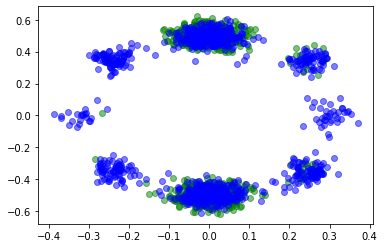

In [32]:
# Sampling from product of distributions
import matplotlib.pyplot as plt

dim = 2
n_mode = 4
std = .05
init_std = 1.
init_mu = 0.
n_steps = 10
damping = .5
mass_diag_sqrt = 1.
num_leapfrog = 3
samples_per_step = 10
uha_step_size = .03
ula_step_size = .001

batch_size = 1000

rng_seq = hk.PRNGSequence(0)

means = jax.random.normal(next(rng_seq), (n_mode, dim))
comp_dists = distrax.MultivariateNormalDiag(means, jnp.ones_like(means) * std)
pi = distrax.Categorical(logits=jnp.zeros((n_mode,)))
target_dist = distrax.MixtureSameFamily(pi, comp_dists)
initial_dist = distrax.MultivariateNormalDiag(means[0] * 0 + init_mu, init_std * jnp.ones_like(means[0]))


x_init = initial_dist.sample(seed=next(rng_seq), sample_shape=(batch_size,))
logZs = []
n_stepss = [100]

def gradient_function(x, t):
  t = n_steps - jnp.ones((x.shape[0],), dtype=jnp.int32) * t - 1
  return -1 *dual_product_gradient_fn(params, next(rng_seq), x, t)

if ebm:
  def energy_function(x, t):
    t = n_steps - jnp.ones((x.shape[0],), dtype=jnp.int32) * t - 1
    return -1 *dual_product_energy_fn(params, next(rng_seq), x, t)

for n_steps in n_stepss:
  ula_step_sizes = jnp.ones((n_steps,)) * ula_step_size
  uha_step_sizes = jnp.ones((n_steps,)) * uha_step_size

  betas = jnp.linspace(0., 1., n_steps)

  def target_function(x, i):
    beta = betas[i]
    init_lp = initial_dist.log_prob(x)
    targ_lp = target_dist.log_prob(x)
    return beta * targ_lp + (1 - beta) * init_lp

  # Choose MCMC Sampler to use
  # sampler = AnnealedULASampler(n_steps, samples_per_step, ula_step_sizes, initial_dist, target_distribution=None, gradient_function=gradient_function)
  # sampler = AnnealedMALASampler(n_steps, samples_per_step, ula_step_sizes, initial_dist, target_distribution=None, gradient_function=gradient_function, energy_function=energy_function)
  # sampler = AnnealedUHASampler(n_steps, samples_per_step, uha_step_sizes, damping, mass_diag_sqrt, num_leapfrog, initial_dist, target_distribution=None, gradient_function=gradient_function)
  sampler = AnnealedMUHASampler(n_steps, samples_per_step, uha_step_sizes, damping, mass_diag_sqrt, num_leapfrog, initial_dist, target_distribution=None, gradient_function=gradient_function, energy_function=energy_function)

  x_samp, logw, accept = sampler.sample(next(rng_seq), batch_size)
  rng_seq = hk.PRNGSequence(1)
  grad_sample = dual_product_sample_fn(params, next(rng_seq), batch_size, jnp.inf)

  # Samples from MCMC
  plt.scatter(x_samp[:, 0], x_samp[:, 1], color='green', alpha=.5)

  # Samples from adding score functions
  plt.scatter(grad_sample[:, 0], grad_sample[:, 1], color='blue', alpha=.5)

  plt.show()

Excute Disjunction Composition

In [ ]:
# Train Left Bar EBM Model
batch_size = 1000
data_dim = 2
num_steps = 15001

EMA = .999

n_steps = 100
net_params = {"n_layers": 4,
              "h_dim": 128,
              "emb_dim": 32}

def forward_fn():
  net = ResnetDiffusionModel(n_steps=n_steps, n_layers=4, x_dim=data_dim, h_dim=128, emb_dim=32)

  if ebm:
    net = EBMDiffusionModel(net)

  ddpm = PortableDiffusionModel(data_dim, n_steps, net, var_type="beta_forward")

  def logp_unnorm(x, t):
    scale_e = ddpm.energy_scale(-2 - t)
    t = jnp.ones((x.shape[0],), dtype=jnp.int32) * t
    return -net.neg_logp_unnorm(x, t) * scale_e

  def _logpx(x):
    return ddpm.logpx(x)["logpx"]
  return ddpm.loss, (ddpm.loss, ddpm.sample, _logpx, logp_unnorm)

forward = hk.multi_transform(forward_fn)
rng_seq = hk.PRNGSequence(0)

xr = [-.75, .75]
yr = [-.75, .75]


def plot_samples(x):
  plt.scatter(x[:, 0], x[:, 1])
  plt.xlim(-2, 2)
  plt.ylim(-2, 2)

def dist_show_2d(fn, xr, yr):
    nticks = 100
    x, y = np.meshgrid(np.linspace(xr[0], xr[1], nticks), np.linspace(yr[0], yr[1], nticks))
    coord = np.stack([x, y], axis=-1).reshape((-1, 2))
    heatmap = fn(coord).reshape((nticks, nticks))
    plt.imshow(heatmap)

# load data
dataset_energy, dataset_sample = left_bar()
x = dataset_sample(batch_size)

plot_samples(x)
plt.show()
x = x.reshape(x.shape[0], -1)


params = forward.init(next(rng_seq), x)
loss_fn, sample_fn, logpx_fn, logp_unnorm_fn = forward.apply
param_count = sum(x.size for x in jax.tree_leaves(params))
for k, v in jax.tree_map(lambda x: x.shape, params).items():
  print(k, v)
print("Model has {} params".format(param_count))


opt = optax.adam(1e-3)
opt_state = opt.init(params)

sample_fn = jax.jit(sample_fn, static_argnums=2)
logpx_fn = jax.jit(logpx_fn)

logp_unnorm_fn = jax.jit(logp_unnorm_fn)

@jax.jit
def mean_loss_fn(params, rng, x):
  loss = loss_fn(params, rng, x)
  return loss.mean()

@jax.jit
def update(params, opt_state, rng, x):
  loss, grad = jax.value_and_grad(mean_loss_fn)(params, rng, x)

  updates, opt_state = opt.update(grad, opt_state)
  new_params = optax.apply_updates(params, updates)
  return loss, new_params, opt_state

ema_params = params
losses = []
test_logpx = []
itr = 0

for itr in range(num_steps):
  x = dataset_sample(batch_size)

  x = x.reshape(x.shape[0], -1)
  start_time = time.time()
  loss, params, opt_state = update(params, opt_state, next(rng_seq), x)
  duration_update = time.time() - start_time
  ema_params = jax.tree_map(lambda e, p: e * EMA + p * (1 - EMA), ema_params, params)

  if itr % 100 == 0:
    print(itr, loss, "time:", duration_update)
    losses.append(loss)
  if itr % 1000 == 0:
    x_samp = sample_fn(ema_params, next(rng_seq), batch_size)
    plot_samples(x_samp)
    plt.show()
    logpx = logpx_fn(ema_params, next(rng_seq), x).mean()
    print("TEST", itr, 'logpx', logpx)
    test_logpx.append(logpx)

    if ebm:
      for t in range(10):
        dist_show_2d(lambda x: logp_unnorm_fn(ema_params, next(rng_seq), x, 10*t), xr=xr, yr=yr)
        plt.show()

plt.plot(losses)
plt.show()
plt.plot(test_logpx)

flow_params = params
flow_rng = next(rng_seq)

left_bar_params = ema_params

In [ ]:
# Train Right Bar EBM Model
batch_size = 1000
data_dim = 2
num_steps = 15001

EMA = .999

n_steps = 100
net_params = {"n_layers": 4,
              "h_dim": 128,
              "emb_dim": 32}

def forward_fn():
  net = ResnetDiffusionModel(n_steps=n_steps, n_layers=4, x_dim=data_dim, h_dim=128, emb_dim=32)

  if ebm:
    net = EBMDiffusionModel(net)

  ddpm = PortableDiffusionModel(data_dim, n_steps, net, var_type="beta_forward")

  def logp_unnorm(x, t):
    scale_e = ddpm.energy_scale(-2 - t)
    t = jnp.ones((x.shape[0],), dtype=jnp.int32) * t
    return -net.neg_logp_unnorm(x, t) * scale_e

  def _logpx(x):
    return ddpm.logpx(x)["logpx"]
  return ddpm.loss, (ddpm.loss, ddpm.sample, _logpx, logp_unnorm)

forward = hk.multi_transform(forward_fn)
rng_seq = hk.PRNGSequence(0)

xr = [-.75, .75]
yr = [-.75, .75]


def plot_samples(x):
  plt.scatter(x[:, 0], x[:, 1])
  plt.xlim(-2, 2)
  plt.ylim(-2, 2)

def dist_show_2d(fn, xr, yr):
    nticks = 100
    x, y = np.meshgrid(np.linspace(xr[0], xr[1], nticks), np.linspace(yr[0], yr[1], nticks))
    coord = np.stack([x, y], axis=-1).reshape((-1, 2))
    heatmap = fn(coord).reshape((nticks, nticks))
    plt.imshow(heatmap)

# load data
dataset_energy, dataset_sample = right_bar()
x = dataset_sample(batch_size)

plot_samples(x)
plt.show()
x = x.reshape(x.shape[0], -1)


params = forward.init(next(rng_seq), x)
loss_fn, sample_fn, logpx_fn, logp_unnorm_fn = forward.apply
param_count = sum(x.size for x in jax.tree_leaves(params))
for k, v in jax.tree_map(lambda x: x.shape, params).items():
  print(k, v)
print("Model has {} params".format(param_count))


opt = optax.adam(1e-3)
opt_state = opt.init(params)

sample_fn = jax.jit(sample_fn, static_argnums=2)
logpx_fn = jax.jit(logpx_fn)

logp_unnorm_fn = jax.jit(logp_unnorm_fn)

@jax.jit
def mean_loss_fn(params, rng, x):
  loss = loss_fn(params, rng, x)
  return loss.mean()

@jax.jit
def update(params, opt_state, rng, x):
  loss, grad = jax.value_and_grad(mean_loss_fn)(params, rng, x)

  updates, opt_state = opt.update(grad, opt_state)
  new_params = optax.apply_updates(params, updates)
  return loss, new_params, opt_state

ema_params = params
losses = []
test_logpx = []
itr = 0

for itr in range(num_steps):
  x = dataset_sample(batch_size)

  x = x.reshape(x.shape[0], -1)
  start_time = time.time()
  loss, params, opt_state = update(params, opt_state, next(rng_seq), x)
  duration_update = time.time() - start_time
  ema_params = jax.tree_map(lambda e, p: e * EMA + p * (1 - EMA), ema_params, params)

  if itr % 100 == 0:
    print(itr, loss, "time:", duration_update)
    losses.append(loss)
  if itr % 1000 == 0:
    x_samp = sample_fn(ema_params, next(rng_seq), batch_size)
    plot_samples(x_samp)
    plt.show()
    logpx = logpx_fn(ema_params, next(rng_seq), x).mean()
    print("TEST", itr, 'logpx', logpx)
    test_logpx.append(logpx)

    if ebm:
      for t in range(10):
        dist_show_2d(lambda x: logp_unnorm_fn(ema_params, next(rng_seq), x, 10*t), xr=xr, yr=yr)
        plt.show()

plt.plot(losses)
plt.show()
plt.plot(test_logpx)

flow_params = params
flow_rng = next(rng_seq)

right_bar_params = ema_params

In [35]:
params = {}

for k, v in left_bar_params.items():
  params[k] = v

for k, v in right_bar_params.items():
  k = k.replace('resnet_diffusion_model/', 'resnet_diffusion_model_1/')
  params[k] = v

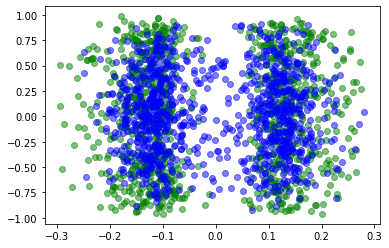

In [37]:
# Sampling from disjunction of distributions
import matplotlib.pyplot as plt

dim = 2
n_mode = 4
std = .05
init_std = 1.
init_mu = 0.
n_steps = 10
damping = .5
mass_diag_sqrt = 1.
num_leapfrog = 3
samples_per_step = 10
uha_step_size = .03
ula_step_size = .001

batch_size = 1000

rng_seq = hk.PRNGSequence(0)

means = jax.random.normal(next(rng_seq), (n_mode, dim))
comp_dists = distrax.MultivariateNormalDiag(means, jnp.ones_like(means) * std)
pi = distrax.Categorical(logits=jnp.zeros((n_mode,)))
target_dist = distrax.MixtureSameFamily(pi, comp_dists)
initial_dist = distrax.MultivariateNormalDiag(means[0] * 0 + init_mu, init_std * jnp.ones_like(means[0]))


x_init = initial_dist.sample(seed=next(rng_seq), sample_shape=(batch_size,))
logZs = []
n_stepss = [100]

def gradient_function(x, t):
  t = n_steps - jnp.ones((x.shape[0],), dtype=jnp.int32) * t - 1
  return -1 *dual_mixture_gradient_fn(params, next(rng_seq), x, t)

if ebm:
  def energy_function(x, t):
    t = n_steps - jnp.ones((x.shape[0],), dtype=jnp.int32) * t - 1
    return -1 *dual_mixture_energy_fn(params, next(rng_seq), x, t)

for n_steps in n_stepss:
  ula_step_sizes = jnp.ones((n_steps,)) * ula_step_size
  uha_step_sizes = jnp.ones((n_steps,)) * uha_step_size

  betas = jnp.linspace(0., 1., n_steps)

  def target_function(x, i):
    beta = betas[i]
    init_lp = initial_dist.log_prob(x)
    targ_lp = target_dist.log_prob(x)
    return beta * targ_lp + (1 - beta) * init_lp

  # Choose the sampler to use
  # sampler = AnnealedULASampler(n_steps, samples_per_step, ula_step_sizes, initial_dist, target_distribution=None, gradient_function=gradient_function)
  # sampler = AnnealedMALASampler(n_steps, samples_per_step, ula_step_sizes, initial_dist, target_distribution=None, gradient_function=gradient_function, energy_function=energy_function)
  # sampler = AnnealedUHASampler(n_steps, samples_per_step, uha_step_sizes, damping, mass_diag_sqrt, num_leapfrog, initial_dist, target_distribution=None, gradient_function=gradient_function)
  sampler = AnnealedMUHASampler(n_steps, samples_per_step, uha_step_sizes, damping, mass_diag_sqrt, num_leapfrog, initial_dist, target_distribution=None, gradient_function=gradient_function, energy_function=energy_function)

  x_samp, logw, accept = sampler.sample(next(rng_seq), batch_size)
  rng_seq = hk.PRNGSequence(1)
  grad_sample = dual_mixture_sample_fn(params, next(rng_seq), batch_size, jnp.inf)

  # Samples from MCMC
  plt.scatter(x_samp[:, 0], x_samp[:, 1], color='green', alpha=.5)

  # Samples generated from adding score function
  plt.scatter(grad_sample[:, 0], grad_sample[:, 1], color='blue', alpha=.5)


  plt.show()

Excute Negation Composition

In [ ]:
batch_size = 1000
data_dim = 2
num_steps = 15001

EMA = .999

n_steps = 100
net_params = {"n_layers": 4,
              "h_dim": 128,
              "emb_dim": 32}

def forward_fn():
  net = ResnetDiffusionModel(n_steps=n_steps, n_layers=4, x_dim=data_dim, h_dim=128, emb_dim=32)

  if ebm:
    net = EBMDiffusionModel(net)

  ddpm = PortableDiffusionModel(data_dim, n_steps, net, var_type="beta_forward")

  def logp_unnorm(x, t):
    scale_e = ddpm.energy_scale(-2 - t)
    t = jnp.ones((x.shape[0],), dtype=jnp.int32) * t
    return -net.neg_logp_unnorm(x, t) * scale_e

  def _logpx(x):
    return ddpm.logpx(x)["logpx"]
  return ddpm.loss, (ddpm.loss, ddpm.sample, _logpx, logp_unnorm)

forward = hk.multi_transform(forward_fn)
rng_seq = hk.PRNGSequence(0)

xr = [-.75, .75]
yr = [-.75, .75]


def plot_samples(x):
  plt.scatter(x[:, 0], x[:, 1])
  plt.xlim(-2, 2)
  plt.ylim(-2, 2)

def dist_show_2d(fn, xr, yr):
    nticks = 100
    x, y = np.meshgrid(np.linspace(xr[0], xr[1], nticks), np.linspace(yr[0], yr[1], nticks))
    coord = np.stack([x, y], axis=-1).reshape((-1, 2))
    heatmap = fn(coord).reshape((nticks, nticks))
    plt.imshow(heatmap)

# load data
dataset_energy, dataset_sample = toy_box(scale=0.7)
x = dataset_sample(batch_size)

plot_samples(x)
plt.show()
x = x.reshape(x.shape[0], -1)


params = forward.init(next(rng_seq), x)
loss_fn, sample_fn, logpx_fn, logp_unnorm_fn = forward.apply
param_count = sum(x.size for x in jax.tree_leaves(params))
for k, v in jax.tree_map(lambda x: x.shape, params).items():
  print(k, v)
print("Model has {} params".format(param_count))


opt = optax.adam(1e-3)
opt_state = opt.init(params)

sample_fn = jax.jit(sample_fn, static_argnums=2)
logpx_fn = jax.jit(logpx_fn)

logp_unnorm_fn = jax.jit(logp_unnorm_fn)

@jax.jit
def mean_loss_fn(params, rng, x):
  loss = loss_fn(params, rng, x)
  return loss.mean()

@jax.jit
def update(params, opt_state, rng, x):
  loss, grad = jax.value_and_grad(mean_loss_fn)(params, rng, x)

  updates, opt_state = opt.update(grad, opt_state)
  new_params = optax.apply_updates(params, updates)
  return loss, new_params, opt_state

ema_params = params
losses = []
test_logpx = []
itr = 0

for itr in range(num_steps):
  x = dataset_sample(batch_size)

  x = x.reshape(x.shape[0], -1)
  start_time = time.time()
  loss, params, opt_state = update(params, opt_state, next(rng_seq), x)
  duration_update = time.time() - start_time
  ema_params = jax.tree_map(lambda e, p: e * EMA + p * (1 - EMA), ema_params, params)

  if itr % 100 == 0:
    print(itr, loss, "time:", duration_update)
    losses.append(loss)
  if itr % 1000 == 0:
    x_samp = sample_fn(ema_params, next(rng_seq), batch_size)
    plot_samples(x_samp)
    plt.show()
    logpx = logpx_fn(ema_params, next(rng_seq), x).mean()
    print("TEST", itr, 'logpx', logpx)
    test_logpx.append(logpx)

    if ebm:
      for t in range(10):
        dist_show_2d(lambda x: logp_unnorm_fn(ema_params, next(rng_seq), x, 10*t), xr=xr, yr=yr)
        plt.show()

plt.plot(losses)
plt.show()
plt.plot(test_logpx)

large_box_params = ema_params

In [ ]:
batch_size = 1000
data_dim = 2
num_steps = 15001

EMA = .999

n_steps = 100
net_params = {"n_layers": 4,
              "h_dim": 128,
              "emb_dim": 32}

def forward_fn():
  net = ResnetDiffusionModel(n_steps=n_steps, n_layers=4, x_dim=data_dim, h_dim=128, emb_dim=32)

  if ebm:
    net = EBMDiffusionModel(net)

  ddpm = PortableDiffusionModel(data_dim, n_steps, net, var_type="beta_forward")

  def logp_unnorm(x, t):
    scale_e = ddpm.energy_scale(-2 - t)
    t = jnp.ones((x.shape[0],), dtype=jnp.int32) * t
    return -net.neg_logp_unnorm(x, t) * scale_e

  def _logpx(x):
    return ddpm.logpx(x)["logpx"]
  return ddpm.loss, (ddpm.loss, ddpm.sample, _logpx, logp_unnorm)

forward = hk.multi_transform(forward_fn)
rng_seq = hk.PRNGSequence(0)

xr = [-.75, .75]
yr = [-.75, .75]


def plot_samples(x):
  plt.scatter(x[:, 0], x[:, 1])
  plt.xlim(-2, 2)
  plt.ylim(-2, 2)

def dist_show_2d(fn, xr, yr):
    nticks = 100
    x, y = np.meshgrid(np.linspace(xr[0], xr[1], nticks), np.linspace(yr[0], yr[1], nticks))
    coord = np.stack([x, y], axis=-1).reshape((-1, 2))
    heatmap = fn(coord).reshape((nticks, nticks))
    plt.imshow(heatmap)

# load data
dataset_energy, dataset_sample = toy_box(scale=0.3)
x = dataset_sample(batch_size)

plot_samples(x)
plt.show()
x = x.reshape(x.shape[0], -1)


params = forward.init(next(rng_seq), x)
loss_fn, sample_fn, logpx_fn, logp_unnorm_fn = forward.apply
param_count = sum(x.size for x in jax.tree_leaves(params))
for k, v in jax.tree_map(lambda x: x.shape, params).items():
  print(k, v)
print("Model has {} params".format(param_count))


opt = optax.adam(1e-3)
opt_state = opt.init(params)

sample_fn = jax.jit(sample_fn, static_argnums=2)
logpx_fn = jax.jit(logpx_fn)

logp_unnorm_fn = jax.jit(logp_unnorm_fn)

@jax.jit
def mean_loss_fn(params, rng, x):
  loss = loss_fn(params, rng, x)
  return loss.mean()

@jax.jit
def update(params, opt_state, rng, x):
  loss, grad = jax.value_and_grad(mean_loss_fn)(params, rng, x)

  updates, opt_state = opt.update(grad, opt_state)
  new_params = optax.apply_updates(params, updates)
  return loss, new_params, opt_state

ema_params = params
losses = []
test_logpx = []
itr = 0

for itr in range(num_steps):
  x = dataset_sample(batch_size)

  x = x.reshape(x.shape[0], -1)
  start_time = time.time()
  loss, params, opt_state = update(params, opt_state, next(rng_seq), x)
  duration_update = time.time() - start_time
  ema_params = jax.tree_map(lambda e, p: e * EMA + p * (1 - EMA), ema_params, params)

  if itr % 100 == 0:
    print(itr, loss, "time:", duration_update)
    losses.append(loss)
  if itr % 1000 == 0:
    x_samp = sample_fn(ema_params, next(rng_seq), batch_size)
    plot_samples(x_samp)
    plt.show()
    logpx = logpx_fn(ema_params, next(rng_seq), x).mean()
    print("TEST", itr, 'logpx', logpx)
    test_logpx.append(logpx)

    if ebm:
      for t in range(10):
        dist_show_2d(lambda x: logp_unnorm_fn(ema_params, next(rng_seq), x, 10*t), xr=xr, yr=yr)
        plt.show()

plt.plot(losses)
plt.show()
plt.plot(test_logpx)

small_box_params = ema_params

In [40]:
params = {}

for k, v in large_box_params.items():
  params[k] = v

for k, v in small_box_params.items():
  k = k.replace('resnet_diffusion_model/', 'resnet_diffusion_model_1/')
  params[k] = v

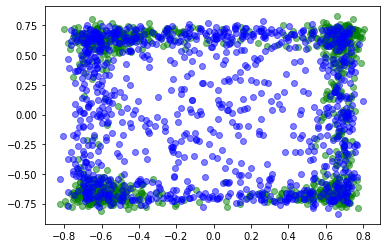

In [42]:
# Sampling from negation of distributions
import matplotlib.pyplot as plt

dim = 2
n_mode = 4
std = .05
init_std = 1.
init_mu = 0.
n_steps = 10
damping = .5
mass_diag_sqrt = 1.
num_leapfrog = 3
samples_per_step = 10
uha_step_size = .03
ula_step_size = .001

batch_size = 1000

rng_seq = hk.PRNGSequence(0)

means = jax.random.normal(next(rng_seq), (n_mode, dim))
comp_dists = distrax.MultivariateNormalDiag(means, jnp.ones_like(means) * std)
pi = distrax.Categorical(logits=jnp.zeros((n_mode,)))
target_dist = distrax.MixtureSameFamily(pi, comp_dists)
initial_dist = distrax.MultivariateNormalDiag(means[0] * 0 + init_mu, init_std * jnp.ones_like(means[0]))


x_init = initial_dist.sample(seed=next(rng_seq), sample_shape=(batch_size,))
logZs = []
n_stepss = [100]

def gradient_function(x, t):
  t = n_steps - jnp.ones((x.shape[0],), dtype=jnp.int32) * t - 1
  return -1 *dual_negation_gradient_fn(params, next(rng_seq), x, t)

if ebm:
  def energy_function(x, t):
    t = n_steps - jnp.ones((x.shape[0],), dtype=jnp.int32) * t - 1
    return -1 *dual_negation_energy_fn(params, next(rng_seq), x, t)

for n_steps in n_stepss:
  ula_step_sizes = jnp.ones((n_steps,)) * ula_step_size
  uha_step_sizes = jnp.ones((n_steps,)) * uha_step_size

  betas = jnp.linspace(0., 1., n_steps)

  def target_function(x, i):
    #print(x.shape)
    beta = betas[i]
    init_lp = initial_dist.log_prob(x)
    targ_lp = target_dist.log_prob(x)
    return beta * targ_lp + (1 - beta) * init_lp

  # Choose the sampler to use
  # sampler = AnnealedULASampler(n_steps, samples_per_step, ula_step_sizes, initial_dist, target_distribution=None, gradient_function=gradient_function)
  # sampler = AnnealedMALASampler(n_steps, samples_per_step, ula_step_sizes, initial_dist, target_distribution=None, gradient_function=gradient_function, energy_function=energy_function)
  # sampler = AnnealedUHASampler(n_steps, samples_per_step, uha_step_sizes, damping, mass_diag_sqrt, num_leapfrog, initial_dist, target_distribution=None, gradient_function=gradient_function)
  sampler = AnnealedMUHASampler(n_steps, samples_per_step, uha_step_sizes, damping, mass_diag_sqrt, num_leapfrog, initial_dist, target_distribution=None, gradient_function=gradient_function, energy_function=energy_function)

  # Generate sample with MCMC
  x_samp, logw, accept = sampler.sample(next(rng_seq), batch_size)
  rng_seq = hk.PRNGSequence(1)

  # Samples generated by adding score function
  grad_sample = dual_negation_sample_fn(params, next(rng_seq), batch_size, jnp.inf)

  # Samples from MCMC
  plt.scatter(x_samp[:, 0], x_samp[:, 1], color='green', alpha=.5)

  # Samples from adding score
  plt.scatter(grad_sample[:, 0], grad_sample[:, 1], color='blue', alpha=.5)

  plt.show()

In [ ]:
def gen_plot_nice(pts):
    plt.scatter(pts[:, 0], pts[:, 1], c='b')
    ax = plt.gca()

    plt.xlim(-1, 1)
    plt.ylim(-1, 1)

    for axis in ['top', 'bottom', 'left', 'right']:
        ax.spines[axis].set_linewidth(1.5)

    ax.set_xticks([], [])
    ax.set_yticks([], [])